# 2025-09-03 Rootfinding

* Review condition numbers

* Forward and backward error

* Volume of a polygon

* Rootfinding examples

* Bisection

## Reliability

**Reliablility** comes from well-conditioned operations and stable algorithms

### Well-conditioned operations

* Modeling turns an abstract question into a mathematical function

* We want well-conditioned models ($\kappa$)

* Some systems are inherantly sensitive though (fracture, chaotic systems, combustion, etc)

### Stable algorithms

* An algorithm `f(x)` may be unstable

* These algorithms are unreliable, but may be practical

* Unstable algorithms are constructed from ill-conditioned parts

## Forward and backward error

* **Forward error** is the difference between our result and the true solution

* **Backward error** tells us which problem our result is the solution for

Additional reading: [FNC](https://fncbook.com/stability)

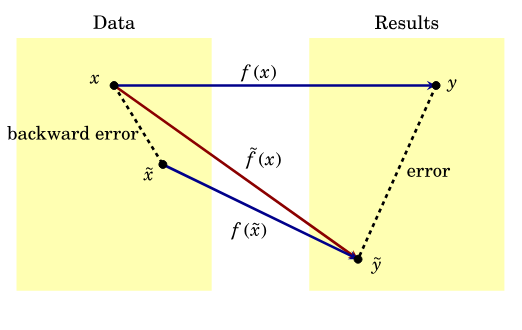

## An ill-conditioned problem from Paul Olum

From [Surely You're Joking, Mr. Feynman](https://sistemas.fciencias.unam.mx/%7Ecompcuantica/RICHARD%20P.%20FEYNMAN-SURELY%20YOU%27RE%20JOKING%20MR.%20FEYNMAN.PDF) (p 113)

> So Paul is walking past the lunch place and these guys are all excited. “Hey, Paul!” they call out. “Feynman’s terrific! We give him a problem that can be stated in ten seconds, and in a minute he gets the answer to 10 percent. Why don’t you give him one?” Without hardly stopping, he says, “The tangent of 10 to the 100th.” I was sunk: you have to divide by pi to 100 decimal places! It was hopeless.

In [1]:
tan(BigFloat("1e100", precision=400))

0.4012319619908143541857543436532949583238702611292440683194415381168718098221194

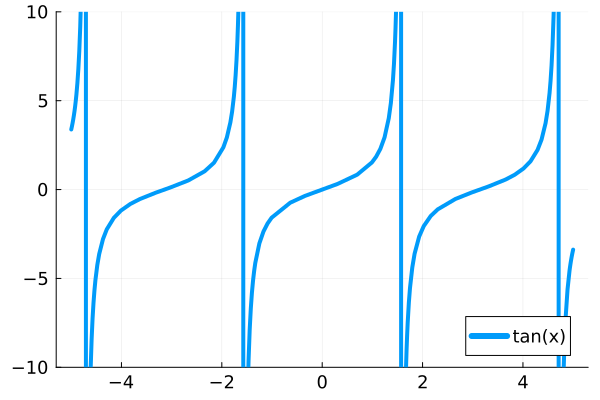

In [2]:
# what values could have answered this question?
using Plots
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

plot(tan, ylims=(-10, 10), x=LinRange(-10, 10, 1000), label="tan(x)")

* For ill-conditioned problems, the best we can hope for is small backward error

* Feynman could have answered with any real number and the relative backward error would have been less than $10^{-100}$. All vaues on the graph above have tiny backward error, as $\tan \left( \text{fl} \left( 10^{100} \right) \right) = \tan \left( 10^{100} \left( 1 + \epsilon \right) \right)$ for some $\epsilon < 10^{-100}$

## Stability - Volume of a polygon

If error exceeds what we can explain via condition numbers, then we call our algorithm **unstable**.

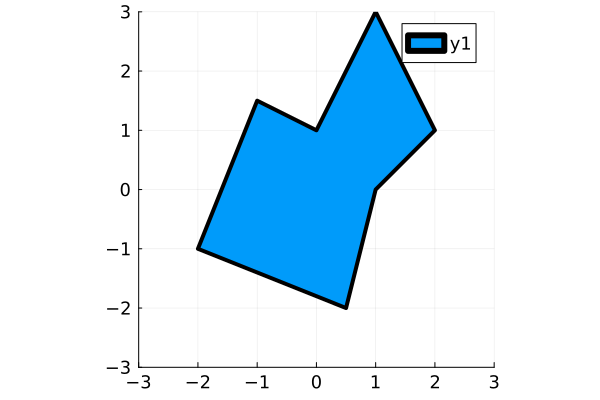

In [3]:
X = [1 0; 2 1; 1 3; 0 1; -1 1.5; -2 -1; .5 -2; 1 0]
plot(X[:,1], X[:,2], seriestype=:shape, aspect_ratio=:equal, xlims=(-3, 3), ylims=(-3, 3))

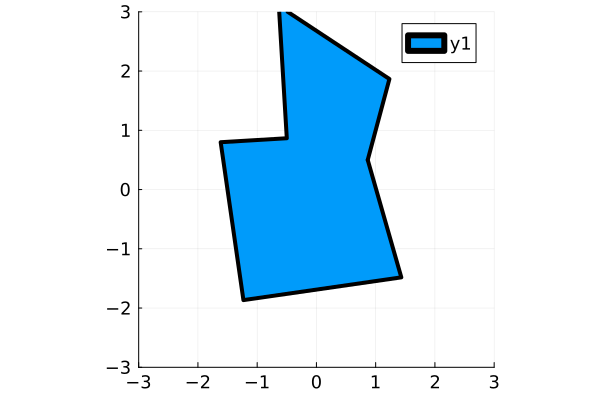

In [4]:
R(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]
Y = X * R(deg2rad(30))' .+ [0 0]
plot(Y[:,1], Y[:,2], seriestype=:shape, aspect_ratio=:equal, xlims=(-3, 3), ylims=(-3, 3))

In [5]:
using LinearAlgebra
function pvolume(X)
    n = size(X, 1)
    vol = sum(det(X[i:i+1, :]) / 2 for i in 1:n-1)
end

@show vol_X = pvolume(X)
@show vol_Y = pvolume(Y)
[det(Y[i:i+1, :]) for i in 1:size(Y, 1)-1]
X

vol_X = pvolume(X) = 9.25
vol_Y = pvolume(Y) = 9.25


8×2 Matrix{Float64}:
  1.0   0.0
  2.0   1.0
  1.0   3.0
  0.0   1.0
 -1.0   1.5
 -2.0  -1.0
  0.5  -2.0
  1.0   0.0

What happens to this algorithm if the polygon is translated, perhaps far away?

## Rootfinding

Given $f \left( x \right)$, find $\tilde{x}$ such that $f \left( \tilde{x} \right) = 0$.

We will start with scalars ($x$ is a single value and $f$ returns a single value) and come back to this with vectors later.

* We don't have $f \left( x \right)$ but rather the algorithm `f(x)` that approximates it.

* Sometimes we have extra information, such as `fp(x)` that approximates $f' \left( x \right)$.

* If we have the source code for `f(x)`, we might be able to transform it to provide `fp(x)`.

### Example: Queueing

In a [simple queueing model](https://en.wikipedia.org/wiki/Queueing_theory#Simple_two-equation_queue), there is an arrival rate and a departure (serving) rate. While waiting in the queue, there is a probability of “dropping out”. The length of the queue in this model is

$$ \text{length} = \frac{\text{arrival} - \text{drop}}{\text{departure}} $$

One model for waiting time (with exponential distributions for rates) is

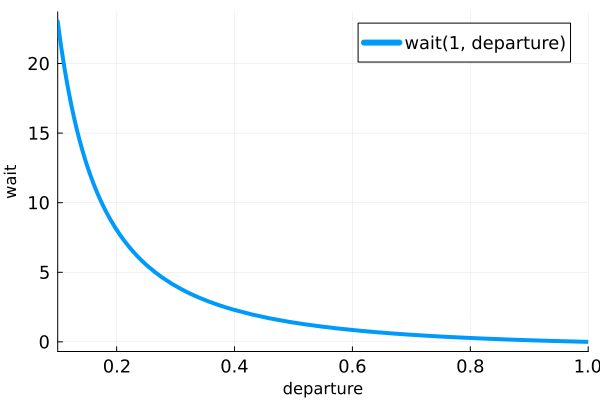

In [6]:
wait(arrival, departure) = log(arrival / departure) / departure

plot(d -> wait(1, d), xlims=(.1, 1), xlabel="departure", ylabel="wait", label="wait(1, departure)")

Suppose I have a maximum threshold for how long I am willing to wait.

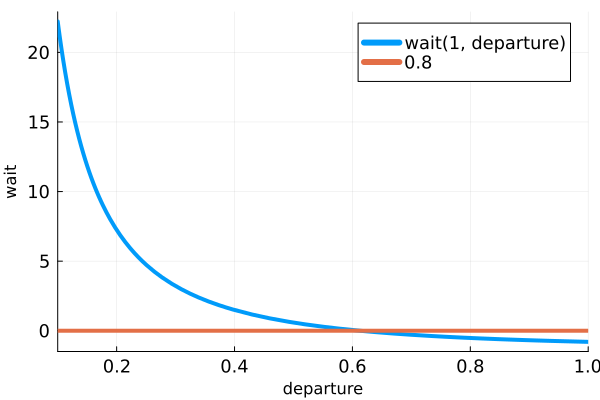

In [7]:
my_wait = 0.8

plot([d -> wait(1, d) - my_wait, d -> 0], xlims=(.1, 1), xlabel="departure", ylabel="wait", label=["wait(1, departure)" "0.8"])

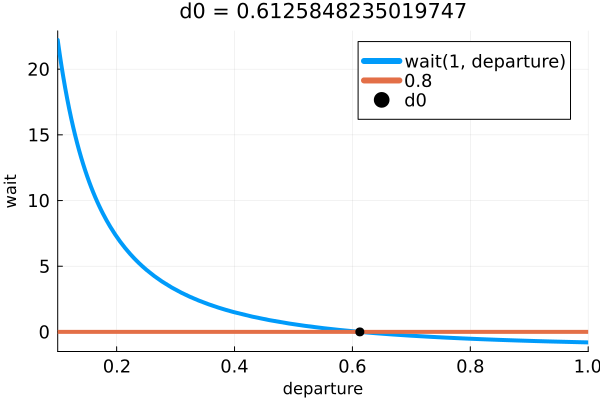

In [8]:
# Lets find the max departure rate where I will leave before my turn
#import Pkg; Pkg.add("Roots")
using Roots
d0 = find_zero(d -> wait(1, d) - my_wait, 1)

plot([d -> wait(1, d) - my_wait, d -> 0], xlims=(.1, 1), xlabel="departure", ylabel="wait", label=["wait(1, departure)" "0.8"])
scatter!([d0], [0], marker=:circle, color=:black, title="d0 = $d0", label="d0")

### Example: Nonlinear Elasticity

#### Strain-energy formulation

$$ W = C_1 \left( I_1 - 3 - 2 \log \left( J \right) \right) + D_1 \left( J - 1 \right)^2 $$

where $I_1 = \lambda_1^2 + \lambda_2^2 + \lambda_3^2$ and $J = \lambda_1 \lambda_2 \lambda_3$ are *invariants* defined in terms of th eprinciple stretches $\lambda_i$

#### [Uniaxial extension](https://en.wikipedia.org/wiki/Neo-Hookean_solid#Compressible_neo-Hookean_material_3)

In that experiment, we want to know the stress as a function of the stretch $\lambda_1$. We don't know $J$, and will have to determine it by solving an equation.

[https://www.youtube.com/watch?v=9N5SS8f1auI&t=60](https://www.youtube.com/watch?v=9N5SS8f1auI&t=60)

#### What is the change of volume?

Using symmetries of uniaxial extension, we can write an equation $f \left( \lambda, J \right) = 0$ that must be satisfield. We'll need to solve a rootfinding problem to compute $J \left( \lambda \right)$.

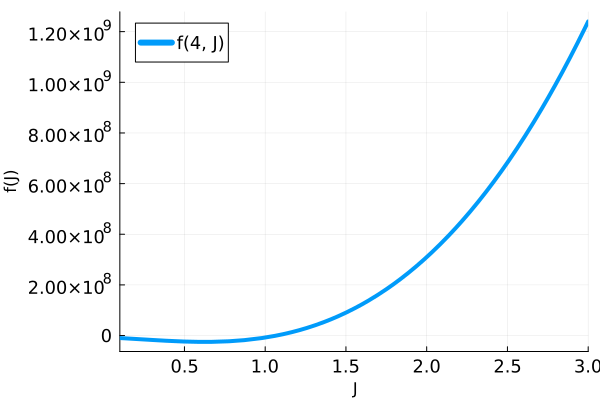

In [9]:
function f(lambda, J)
    C_1 = 1.5e6
    D_1 = 1e8
    D_1 * J^(8/3) - D_1 * J^(5/3) + C_1 / (3*lambda) * J - C_1 * lambda^2/3
end
plot(J -> f(4, J), xlims=(0.1, 3), xlabel="J", ylabel="f(J)", label="f(4, J)")

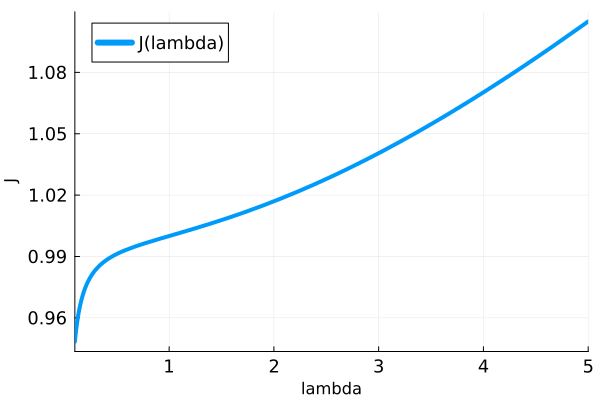

In [10]:
find_J(lambda) = find_zero(J -> f(lambda, J), 1)
plot(find_J, xlims=(0.1, 5), xlabel="lambda", ylabel="J", label="J(lambda)")

## Bisection algorithm

Bisection is a rootfinding algorithm that starts with an interval $\left[ a, b \right]$ containing a root and does not require derivatives.
Suppose $f$ is continuous.
What is a **sufficient** condition for $f$ to have a root on the interval $\left[ a, b \right]$?

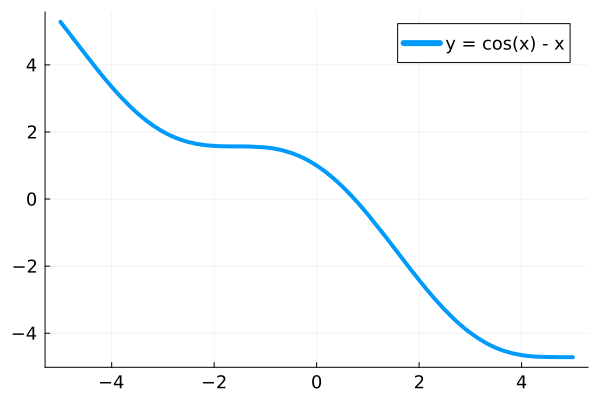

In [11]:
hasroot(f, a, b) = f(a) * f(b) < 0

f(x) = cos(x) - x
plot(f, label="y = cos(x) - x")

### Bisection

In [12]:
function bisect(f, a, b, tol)
    mid = (a + b) / 2
    if abs(b - a) < tol
        return mid
    elseif hasroot(f, a, mid)
        return bisect(f, a, mid, tol)
    else
        return bisect(f, mid, b, tol)
    end
end

x0 = bisect(f, -1, 3, 1e-5)
@show (x0, f(x0));

(x0, f(x0)) = (0.7390861511230469, -1.7035832658995886e-6)


#### What is my convergence rate?

In [13]:
function bisect_hist(f, a, b, tol)
    mid = (a + b) / 2
    if abs(b - a) < tol
        return [mid]
    elseif hasroot(f, a, mid)
        return prepend!(bisect_hist(f, a, mid, tol), [mid])
    else
        return prepend!(bisect_hist(f, mid, b, tol), [mid])
    end
end

bisect_hist(f, -1, 3, 1e-4)

17-element Vector{Float64}:
 1.0
 0.0
 0.5
 0.75
 0.625
 0.6875
 0.71875
 0.734375
 0.7421875
 0.73828125
 0.740234375
 0.7392578125
 0.73876953125
 0.739013671875
 0.7391357421875
 0.73907470703125
 0.739105224609375

### Iterative Bisection

In [14]:
function bisect_iter(f, a, b, tol)
    hist = Float64[]
    while abs(b - a) > tol
        mid = (a + b) / 2
        push!(hist, mid)
        if hasroot(f, a, mid)
            b = mid
        else
            a = mid
        end
    end
    hist
end

bisect_iter(f, -1, 3, 1e-4)

16-element Vector{Float64}:
 1.0
 0.0
 0.5
 0.75
 0.625
 0.6875
 0.71875
 0.734375
 0.7421875
 0.73828125
 0.740234375
 0.7392578125
 0.73876953125
 0.739013671875
 0.7391357421875
 0.73907470703125

### Let's plot the error

$$ \lvert \text{bisect}^k \left( f, a, b \right) - x_* \rvert, k = 1, 2, \dots $$

where $r$ is the true root ($f \left( x_* \right) = 0$).

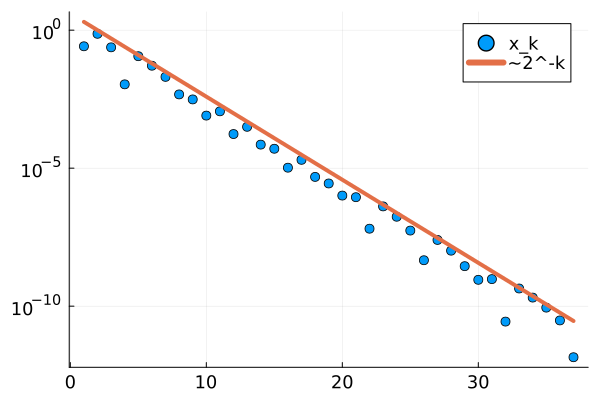

In [15]:
r = bisect(f, -1, 3, 1e-15) # is this a good 'true' root?

hist = bisect_hist(f, -1, 3, 1e-10)
scatter( abs.(hist .- r), yscale=:log10, label="x_k")

ks = 1:length(hist)
plot!(ks, 4 * (.5 .^ ks), label="~2^-k")

So the error $e_k = x_k - x_*$ satisfies the bound

$$ \left\lvert e_k \right\rvert \leq c 2^{-k} $$

## Exploration

* Share an equation on Zulip that is useful for one task but requires rootfinding for another task.

* Or explain a system in which one stakeholder has the natural inputs but a different stakeholder only knows the outputs.

Collaborate!